# README

## Overview
This project applies agglomerative hierarchical clustering to group rock samples based on their geochemical and categorical properties. The clustering uses Gower distance, which is suitable for mixed data types (numerical, categorical, and binary).

## Methodology
### Agglomerative Hierarchical Clustering

This is a bottom-up approach where each sample starts in its own cluster. The two most similar clusters are merged iteratively based on Gower distance until all samples are connected in a hierarchical tree (dendrogram). The tree is then sliced at a selected level to form distinct clusters.

### Encoding Trace Elements
Trace elements (e.g., Ba, Ce, Pb) were converted into binary categorical features:
- 1 if the element is present (non-zero and non-missing)
- 0 if the element is missing or undetected

### Evaluation
Clustering performance was assessed using the Silhouette Score. This score measures how well samples fit within their assigned clusters (higher scores indicate better-defined clusters).

# 1. Hierachical Grower

In [3]:
# import library
import pandas as pd
import numpy as np
!pip install gower
import gower
from gower import gower_matrix
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

In [4]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

**When run the below code chunk, please replace your filepath to the dataset**

Note: The file should be .xlsx

In [6]:
# load data 
file_path = "XRF Data GTRL revised 250122.xlsx"
df = pd.read_excel(file_path)

**You can modify the columns you want to remove**

In [8]:
# Drop unnecessary columns (Modify based on dataset)
columns_to_remove = ['Name/sample', 'M,N', 'Name/sample trace elements', 'Total Columns',
                     'No', 'N', 'P', 'R', 'less O', 'H2O','Total']
df.drop(columns=[col for col in columns_to_remove if col in df.columns], inplace=True)  # in-place drop

# Convert negative values in H2O and MgO to zero (if present)
for col in ['H2O', 'MgO']:
    if col in df.columns:
        df[col] = df[col].apply(lambda x: max(x, 0))

# Ensure all columns are numeric
df = df.replace(',', '.', regex=True) # replace ',' with '.'
df = df.replace("<", "", regex=True) # remove '<'
df = df.apply(pd.to_numeric, errors='coerce')

In [9]:
# Show columns with all NaNs
df.columns[df.isna().all()]
df = df.dropna(axis=1, how='all')

## a. Heat Map

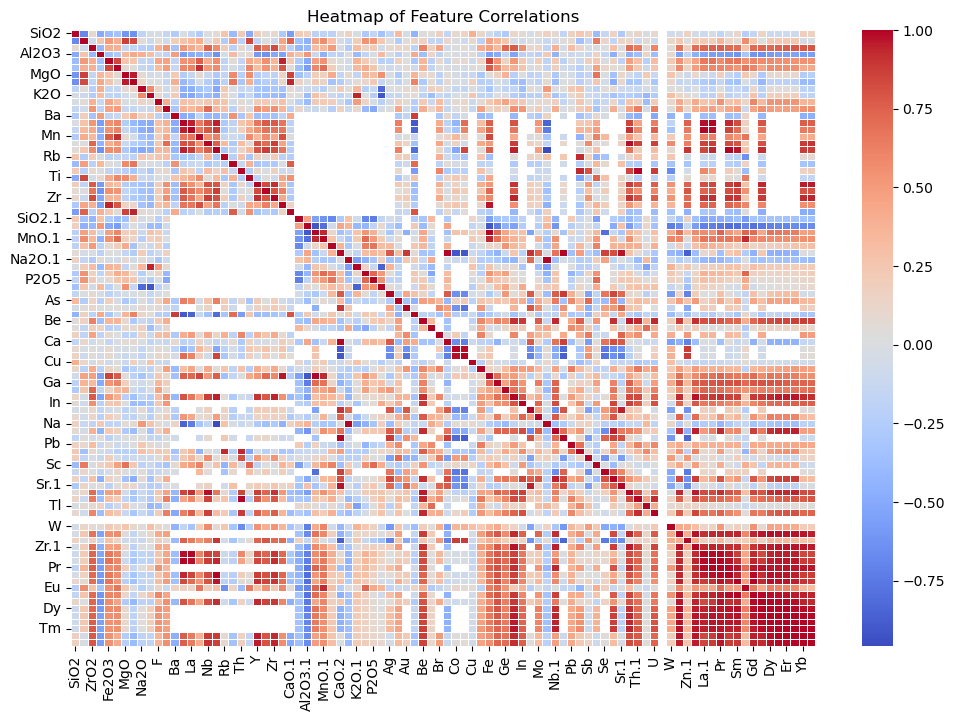

In [11]:
# Heatmap of Correlation Matrix (after removing highly correlated features)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Feature Correlations")
plt.show()  # display plot

In [12]:
# Drop highly correlated features
corr_matrix = df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]

df = df.drop(columns=highly_correlated)  

In [13]:
print(df.columns.tolist())

['SiO2', 'TiO2', 'ZrO2', 'Al2O3', 'Fe2O3', 'MnO', 'Na2O', 'K2O', 'F', 'Cl', 'Ba', 'Ce', 'Nb', 'Rb', 'Sr', 'Th', 'Ti', 'Y', 'SiO2.1', 'Al2O3.1', 'MgO.1', 'CaO.2', 'Na2O.1', 'TiO2.1', 'P2O5', 'Ag', 'As', 'Be', 'Bi', 'Br', 'Cu', 'Cs', 'Ga', 'Ge', 'Mo', 'Pb', 'Sb', 'Sc', 'Tl', 'V', 'W']


## b. Encoding trace elements
Trace elements (e.g., Ba, Ce, Pb) were converted to binary categorical features (0/1), where:
- 1 = the element is present (non-zero and non-missing)
- 0 = the element is missing or undetected

In [15]:
# List of trace elements
trace_elements_list = ['Ba', 'Ce', 'Nb', 'Rb', 'Sr', 'Th', 'Ti', 'Y',
                       'SiO2.1', 'Al2O3.1', 'MgO.1', 'CaO.2', 'Na2O.1', 'TiO2.1', 'P2O5',
                       'Ag', 'As', 'Be', 'Bi', 'Br', 'Cu', 'Cs', 'Ga', 'Ge',
                       'Mo', 'Pb', 'Sb', 'Sc', 'Tl', 'V', 'W']

# Create a new column called "trace_elements"
df['trace_elements'] = np.where(
    (df[trace_elements_list].notna()) & (df[trace_elements_list] != 0),
    1, 0
).any(axis=1).astype(int)

# Drop all the trace element columns
df = df.drop(columns=trace_elements_list)

In [16]:
df.dropna(inplace=True)

In [17]:
df

,SiO2,TiO2,ZrO2,Al2O3,Fe2O3,MnO,Na2O,K2O,F,Cl,trace_elements
0,71.049071,0.238260,0.220406,9.388453,4.677025,0.223485,2.499681,2.237143,0.430250,0.132083,1
1,73.800528,0.333829,0.288396,9.521427,5.336355,0.225637,1.120442,1.575014,0.571500,0.088875,1
2,72.210835,0.299702,0.355711,10.273841,5.000614,0.256088,0.868497,1.118672,0.571667,0.192667,0
3,71.088290,0.246323,0.249448,9.686837,4.074288,0.228220,3.711555,4.305642,0.364167,0.167917,1
4,70.931594,0.203508,0.327569,9.135732,4.752323,0.250493,3.746488,4.208270,0.460500,0.231500,0
...,...,...,...,...,...,...,...,...,...,...,...
1176,71.634440,0.292474,0.000000,10.500161,4.054788,0.166421,1.463370,2.428206,0.266556,0.143889,0
1177,71.306488,0.295671,0.000000,11.767806,3.124252,0.130411,2.001295,2.994033,0.230750,0.120250,0
1178,71.136957,0.260224,0.000000,11.266144,3.519921,0.167210,1.510322,2.515807,0.258500,0.142000,0
1180,69.856646,0.239164,0.463080,8.018448,7.551229,0.373964,1.467947,2.548105,0.515438,0.500625,0


## c. Model - Testing

### Grower
`gower_matrix` from the `gower` package calculates **Gower distance**, which is used to measure similarity (or dissimilarity) between data points that have **mixed types** of features — including:

- **Numerical** (e.g., income, height)  
- **Categorical** (e.g., gender, color)  
- **Binary** (e.g., owns car: yes/no)

#### Why use Gower?
Traditional distance metrics like Euclidean only work well with numerical data. Gower distance is ideal when your dataset includes **categorical or missing values** — which is common in real-world cases like surveys or demographic data.

In [20]:
gower_dist = gower.gower_matrix(df)
condensed = squareform(gower_dist, checks=False)

### Clustering Algorithm: Hierarchical Clustering (Simple Explanation)

We used a method called **agglomerative hierarchical clustering**. Here's how it works:

1. **Start Simple:**  
   At the beginning, every rock sample is treated as its **own cluster**.

2. **Step-by-Step Merging:**  
   The algorithm looks for the **two samples (or clusters)** that are **most similar** based on the Gower distance, and **merges them** into one cluster.

3. **Keep Merging:**  
   This process keeps repeating — merging the closest clusters — until everything is grouped into a big tree structure (called a **dendrogram**).

4. **Cut the Tree:**  
   Instead of using the full tree, we **cut it at a certain level** to form exactly **100 groups (clusters)**. These are the final clusters you see in the results.

5. **Why 'Average Linkage'?**  
   When deciding how similar two clusters are, we look at the **average distance** between all the points in one group and all the points in the other. That’s called **average linkage** — and it’s a balanced way to measure similarity between groups.

In [22]:
# Perform hierarchical clustering
Z = linkage(condensed, method='average')

# Cut dendrogram to form 6 clusters
# You can change the number of cluster by replace 6 to other number you want!
labels = fcluster(Z, t=6, criterion='maxclust')

# Add cluster labels to DataFrame
df['Cluster'] = labels

## 2. Clustering Result

This shows the number of samples in each cluster (group).

In [25]:
cluster_counts = df['Cluster'].value_counts().sort_values(ascending=False).reset_index()
cluster_counts.columns = ['Cluster', 'Sample Count']

pd.set_option('display.max_rows', None)
print(cluster_counts)


   Cluster  Sample Count
0        3           586
1        4           412
2        6            32
3        5             3
4        1             2
5        2             1


## 3. Cluster Quality Evaluation

In [27]:
from sklearn.metrics import silhouette_score

# Silhouette Score — measures how well each sample fits its cluster
score = silhouette_score(gower_dist, df['Cluster'], metric='precomputed')
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.406


#### Visualize cluster quality, the higher the score the better

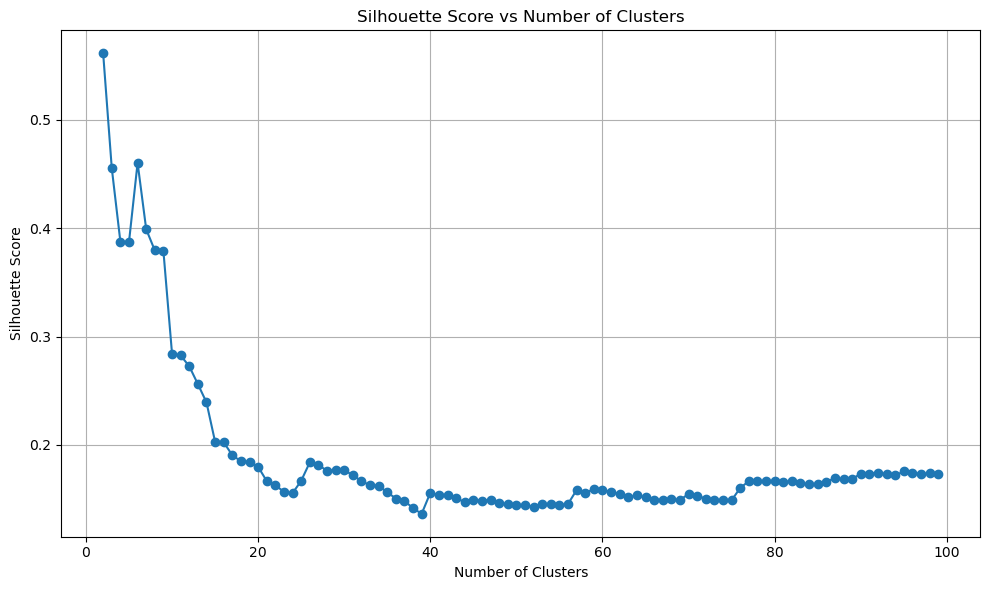

In [29]:
# Step 1: Gower Distance
gower_dist = gower.gower_matrix(df)
condensed = squareform(gower_dist, checks=False)  # for scipy linkage

# Step 2: Silhouette Scores for Range of k
cluster_range = range(2, 100)
sil_scores = []

for k in cluster_range:
    Z = linkage(condensed, method='average')
    labels = fcluster(Z, k, criterion='maxclust')
    score = silhouette_score(gower_dist, labels, metric='precomputed')
    sil_scores.append(score)

# Step 3: Plot
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, sil_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.tight_layout()
plt.show()

## Save Result

In [31]:
# Save or view results
# You can save the cluter outputs by running this line of code. (you can change the name of the excel output by change words in " ")
# df.to_excel("clustered_rock_samples.xlsx", index=False)

## Decision Tree

In [33]:
df['Cluster'].value_counts()

Cluster
3    586
4    412
6     32
5      3
1      2
2      1
Name: count, dtype: int64

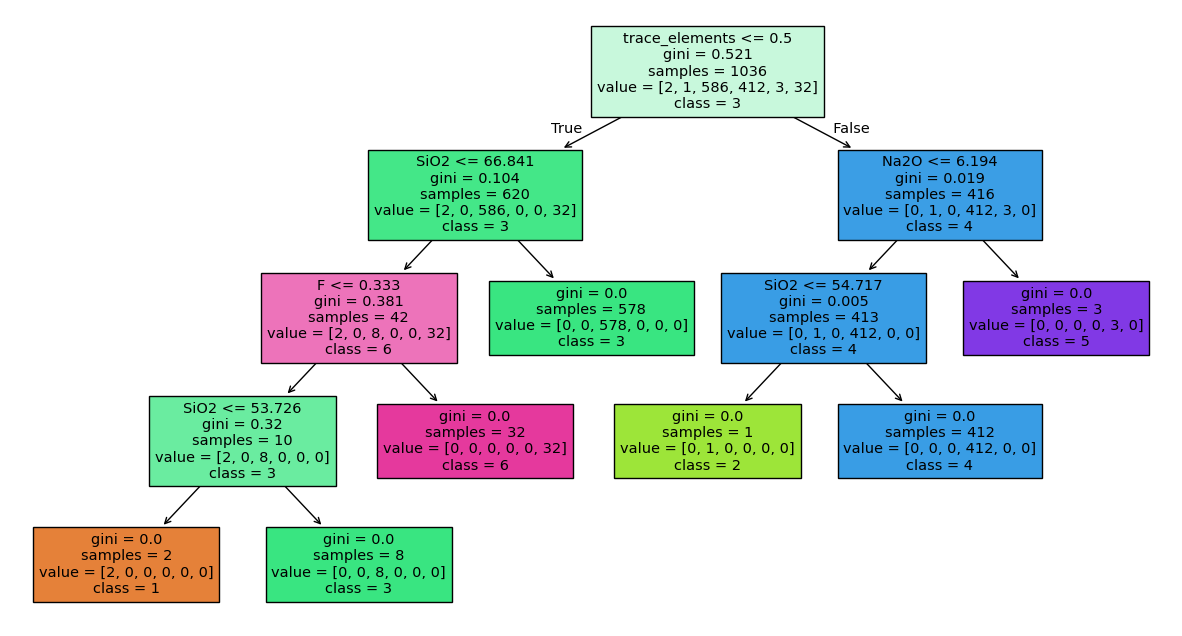

|--- trace_elements <= 0.50
|   |--- SiO2 <= 66.84
|   |   |--- F <= 0.33
|   |   |   |--- SiO2 <= 53.73
|   |   |   |   |--- class: 1
|   |   |   |--- SiO2 >  53.73
|   |   |   |   |--- class: 3
|   |   |--- F >  0.33
|   |   |   |--- class: 6
|   |--- SiO2 >  66.84
|   |   |--- class: 3
|--- trace_elements >  0.50
|   |--- Na2O <= 6.19
|   |   |--- SiO2 <= 54.72
|   |   |   |--- class: 2
|   |   |--- SiO2 >  54.72
|   |   |   |--- class: 4
|   |--- Na2O >  6.19
|   |   |--- class: 5



In [34]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import numpy as np

# Step 1: Prepare Data
X = df.drop(columns="Cluster")  # Features: Chemical Components
y = df["Cluster"]               # Target: Cluster Labels

def find_optimal_depth(X, y):
    scores = []
    depths = range(4, 20)  # Try depths from 2 to 10
    for depth in depths:
        tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
        score = np.mean(cross_val_score(tree, X, y, cv=5))  # 5-fold CV
        scores.append((depth, score))

    best_depth = max(scores, key=lambda x: x[1])[0]
    return best_depth

optimal_depth = find_optimal_depth(X, y)

# Step 2: Train Decision Tree
clf = DecisionTreeClassifier(max_depth=optimal_depth, random_state=42)  # Limit depth for simple rules
clf.fit(X, y)

# Step 3: Visualize Decision Tree
plt.figure(figsize=(15, 8))
plot_tree(clf, feature_names=X.columns, class_names=[str(c) for c in set(y)], filled=True)
plt.show()

# Step 4: Extract Human-Readable Rules
rules = export_text(clf, feature_names=list(X.columns))
print(rules)

## Rule Extraction

In [36]:
import numpy as np
from sklearn.tree import _tree

global_features = []
def get_rules(tree, feature_names, class_names):
    global global_features
    tree_ = tree.tree_

    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            left_path, right_path = list(path), list(path)

            threshold_rounded = np.round(threshold, 3)

            if name == "trace_elements" and threshold_rounded == 0.5:
                left_path.append(f"{name} = 0")
                recurse(tree_.children_left[node], left_path, paths)

                right_path.append(f"{name} = 1")
                recurse(tree_.children_right[node], right_path, paths)
            else:
                left_path.append(f"{name} <= {threshold_rounded}")
                recurse(tree_.children_left[node], left_path, paths)

                right_path.append(f"{name} > {threshold_rounded}")
                recurse(tree_.children_right[node], right_path, paths)

        else:
            path.append((tree_.value[node], tree_.n_node_samples[node]))
            paths.append(path)

    recurse(0, path, paths)

    # Sort rules by the number of samples supporting them
    paths.sort(key=lambda p: p[-1][1], reverse=True)

    # Process rules and remove contradictions
    cluster_rules = {}
    for path in paths:
        conditions = path[:-1]
        cluster_probabilities = path[-1][0][0]
        total_samples = path[-1][1]

        # Find the most probable cluster
        cluster_idx = np.argmax(cluster_probabilities)
        cluster_label = class_names[cluster_idx]
        cluster_proba = np.round(100.0 * cluster_probabilities[cluster_idx] / np.sum(cluster_probabilities), 2)

        # Simplify conditions: merge redundant ranges
        simplified_conditions = []
        seen_conditions = {}

        for condition in conditions:
            feature, op, value = condition.split(" ", 2)
            if feature not in seen_conditions:
                seen_conditions[feature] = [condition]
            else:
                # Merge ranges if possible
                existing_conditions = seen_conditions[feature]
                merged = False
                for i, existing in enumerate(existing_conditions):
                    existing_feature, existing_op, existing_value = existing.split(" ", 2)
                    if existing_op == "<=" and op == ">" and existing_value == value:
                        # Merge (A <= x) AND (A > x) → remove contradiction
                        existing_conditions[i] = f"{feature} = {value}"
                        merged = True
                        break
                    elif existing_op == ">" and op == "<=" and existing_value == value:
                        existing_conditions[i] = f"{feature} = {value}"
                        merged = True
                        break
                if not merged:
                    existing_conditions.append(condition)

        # Combine conditions into final rule
        for conditions in seen_conditions.values():
            simplified_conditions.extend(conditions)

        rule_text = " AND ".join(simplified_conditions)
        if cluster_label not in cluster_rules:
            cluster_rules[cluster_label] = []
        cluster_rules[cluster_label].append(f"- {rule_text} (proba: {cluster_proba}%)")

    # Format output as requested
    output_rules = []
    for cluster, rules in cluster_rules.items():
        output_rules.append(f"Cluster {cluster}\n" + "\n".join(rules))

    # Also extract all feature names used
    used_features = sorted(set(
        condition.split(" ", 2)[0]
        for path in paths
        for condition in path[:-1]
    ))

    global_features = used_features

    return "\n\n".join(output_rules)


# Example usage
rules_text = get_rules(clf, X.columns, class_names=[str(c) for c in set(y)])
print(rules_text)

Cluster 3
- trace_elements = 0 AND SiO2 > 66.841 (proba: 100.0%)
- trace_elements = 0 AND SiO2 <= 66.841 AND SiO2 > 53.726 AND F <= 0.333 (proba: 100.0%)

Cluster 4
- trace_elements = 1 AND Na2O <= 6.194 AND SiO2 > 54.717 (proba: 100.0%)

Cluster 6
- trace_elements = 0 AND SiO2 <= 66.841 AND F > 0.333 (proba: 100.0%)

Cluster 5
- trace_elements = 1 AND Na2O > 6.194 (proba: 100.0%)

Cluster 1
- trace_elements = 0 AND SiO2 <= 66.841 AND SiO2 <= 53.726 AND F <= 0.333 (proba: 100.0%)

Cluster 2
- trace_elements = 1 AND Na2O <= 6.194 AND SiO2 <= 54.717 (proba: 100.0%)


In [37]:
global_features

['F', 'Na2O', 'SiO2', 'trace_elements']

## Classify new data point

In [39]:
# Example new data point (must match the order of X.columns)
new_data_point = np.array([[70.312580, 0.265419, 0.198703, 9.572801, 4.432891, 0.241107, 2.617304, 2.115476, 0.9, 0.3, 1]])  # New data point
# Predict the cluster
predicted_cluster = clf.predict(new_data_point)[0]

# If you want to get probabilities
probabilities = clf.predict_proba(new_data_point)[0]

# Output results
print(f"Predicted cluster: {predicted_cluster}")
print("Probability distribution across clusters:")
for label, prob in zip(clf.classes_, probabilities):
    print(f"  Cluster {label}: {round(prob * 100, 2)}%")

Predicted cluster: 4
Probability distribution across clusters:
  Cluster 1: 0.0%
  Cluster 2: 0.0%
  Cluster 3: 0.0%
  Cluster 4: 100.0%
  Cluster 5: 0.0%
  Cluster 6: 0.0%


## Get sample excel tool to classify new data point

In [41]:
import re
from openpyxl import Workbook
from openpyxl.worksheet.datavalidation import DataValidation
from openpyxl.utils import get_column_letter

# ---- Step 1: Parse rules into (condition, cluster) pairs ----
parsed_rules = []

# Split by double newline to separate clusters
clusters = rules_text.strip().split("\n\n")

for cluster_block in clusters:
    lines = cluster_block.strip().split("\n")
    if not lines:
        continue
    cluster_header = lines[0]
    match = re.match(r'Cluster\s+(\d+)', cluster_header)
    if not match:
        continue
    cluster_id = match.group(1)

    for line in lines[1:]:
        if line.startswith("-"):
            condition_part = line.lstrip("- ").split("(proba:")[0].strip()
            parsed_rules.append((condition_part, f"Cluster {cluster_id}"))



# ---- Step 2: Convert conditions to Excel-friendly formula ----

var_to_excel_cell = {
    feature: f"{get_column_letter(i + 1)}2" for i, feature in enumerate(global_features)
}


excel_formula_parts = []
for condition, cluster in parsed_rules:
    expr = condition.replace("AND", "*")
    for var, cell_ref in var_to_excel_cell.items():
        expr = re.sub(rf'\b{var}\b', cell_ref, expr)
    excel_formula_parts.append(f'({expr}, "{cluster}")')

# Add default case
# Build nested IF() formula
nested_if = ""
for condition, cluster in parsed_rules:
    expr = "AND(" + condition.replace("AND", ",") + ")"
    for var, cell_ref in var_to_excel_cell.items():
        expr = re.sub(rf'\b{var}\b', cell_ref, expr)
    if nested_if:
        nested_if = f'IF({expr}, "{cluster}", {nested_if})'
    else:
        nested_if = f'IF({expr}, "{cluster}", "Unclassified")'



excel_formula = f'={nested_if}'


# ---- Step 3: Create Excel Workbook with openpyxl ----
wb = Workbook()
ws = wb.active
ws.title = "Cluster Predictor"

# Write header row
headers = list(var_to_excel_cell.keys()) + ["Predicted_Cluster"]
ws.append(headers)

# Dynamically determine output column (next column after last feature)
from openpyxl.utils import get_column_letter

output_col_index = len(var_to_excel_cell) + 1  # features start at col 1
output_col_letter = get_column_letter(output_col_index)
output_cell = f"{output_col_letter}2"

# Write formula to calculated cell
ws[output_cell] = excel_formula

# Auto-size column widths
for col in ws.columns:
    max_length = max(len(str(cell.value)) if cell.value else 0 for cell in col)
    ws.column_dimensions[col[0].column_letter].width = max_length + 2

# ---- Step 4: Save workbook ----
wb.save("excel_with_inserted_formula.xlsx")
print("Excel file 'excel_with_inserted_formula.xlsx' has been created with rule logic.")

Excel file 'excel_with_inserted_formula.xlsx' has been created with rule logic.
